# Visualizing what PneumoniaNet learned
The author of this notebook is **Dr Raheel Siddiqi**. He is a *Senior Assistant Professor* at Bahria University, Karachi Campus, Pakistan. His research interests include *Medical Imaging*, *Computer Vision* and *Deep Learning*.

The representations learned by convnets are highly amenable to visualization, in large part because they are representations of visual concepts. The objective of this notebook is to visualize the representations learned by *PneumoniaNet*. PneumoniaNet is based on a 20-layer CNN architecture. Details about PneumoniaNet (its structure, training, performance evaluation etc.) are given [here](https://github.com/raheelsiddiqi2013/pneumonia-diagnosis-3/blob/master/PneumoniaNet5.ipynb).

Let's start with loading the PneumoniaNet model.

## PneumoniaNet Model Loaded

In [1]:
from keras.models import load_model

model = load_model('PneumoniaNet5.h5')
model.summary()  # As a reminder.

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 144, 144, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 142, 142, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 71, 71, 128)       0         
_______________________________________

## Sample Chest X-ray Image used as Input

In [2]:
img_path = 'D:\\TensorFlow Programs\\Diagnosis of Pneumonia based on Chest X-Rays\\chest-xray-pneumonia\\chest_xray\\chest_xray\\test\\PNEUMONIA\\person85_bacteria_422.jpeg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


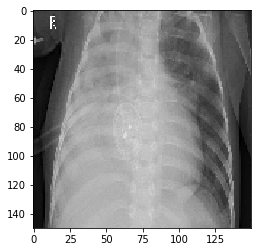

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img_tensor[0])
plt.show()

## Visualizing intermediate activations
Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution, pooling and dropout layers in a network, given a certain input (the output of a layer is often called its "activation", the output of the activation function). This gives a view into how an input is decomposed into the different filters/channels learned by the network. Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel, as a 2D image.

**Our task here is to extract and visualize the feature maps produced by the convolutional, pooling and dropout layers of PneumoniaNet, given the sample chest x-ray image**. We will create a Keras model that takes an input image, and outputs the activations of the first 16 layers of PneumoniaNet (this includes all 10 convolutional layers, the 3 pooling and the 3 dropout layers). To do this, we will use the Keras class `Model`. What sets the `Model` class apart is that it allows for models with multiple outputs, unlike `Sequential`.

In [4]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:16]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in PneumoniaNet.

In [5]:
# This will return a list of 8 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

For instance, this is the activation of the first convolution layer for the Chest X-ray input.

In [6]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 64)


It's a 148x148 feature map with 64 channels. Let's try visualizing the 4th and 5th channels:

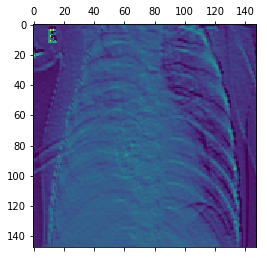

In [19]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')
plt.show()

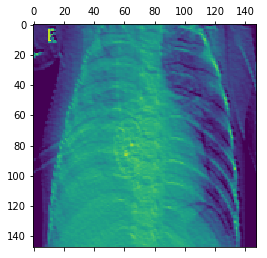

In [20]:
plt.matshow(first_layer_activation[0, :, :, 8], cmap='viridis')
plt.show()

Now, let's visualize all the channels of the first 15 layers.

C:\Users\Raheel\Anaconda3\envs\EnvName\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


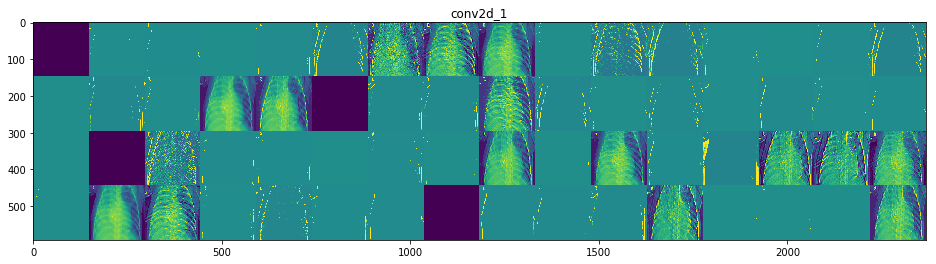

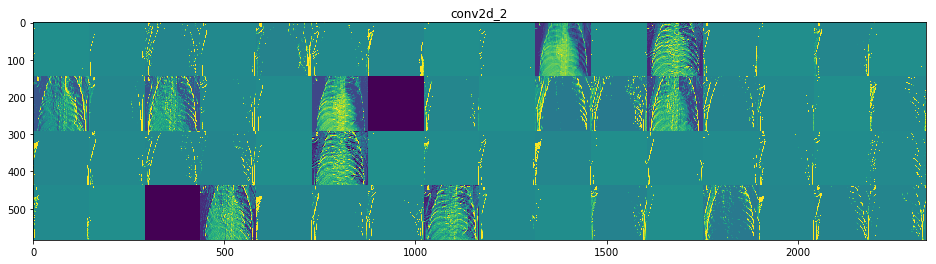

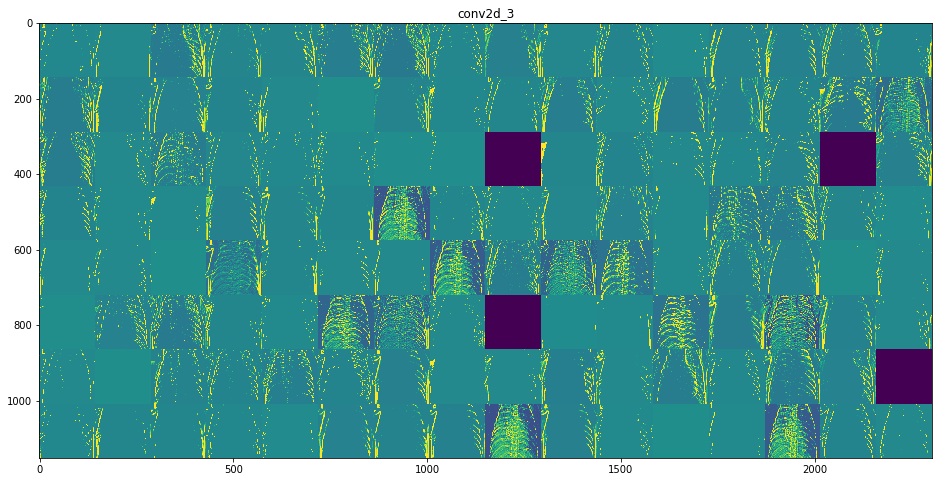

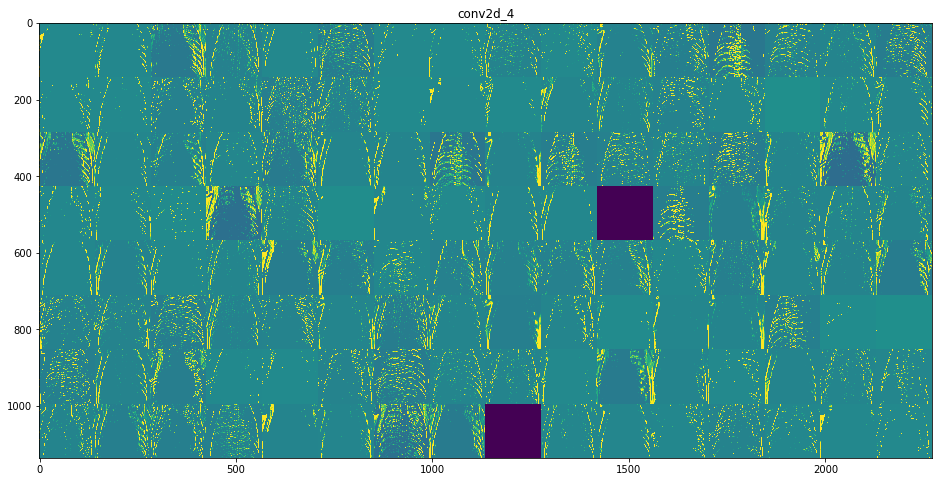

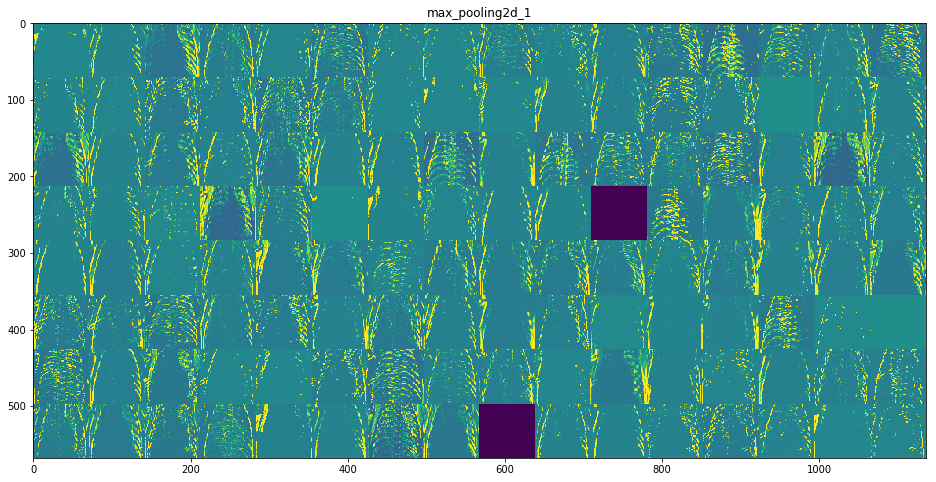

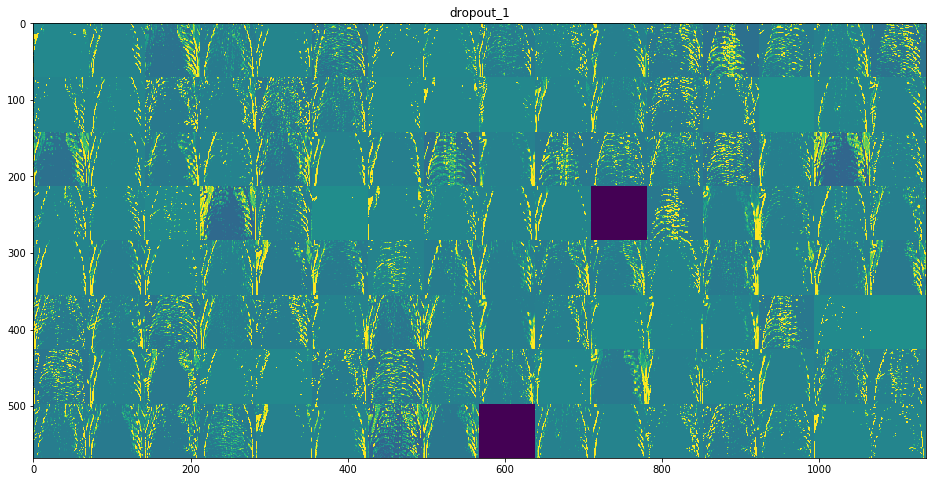

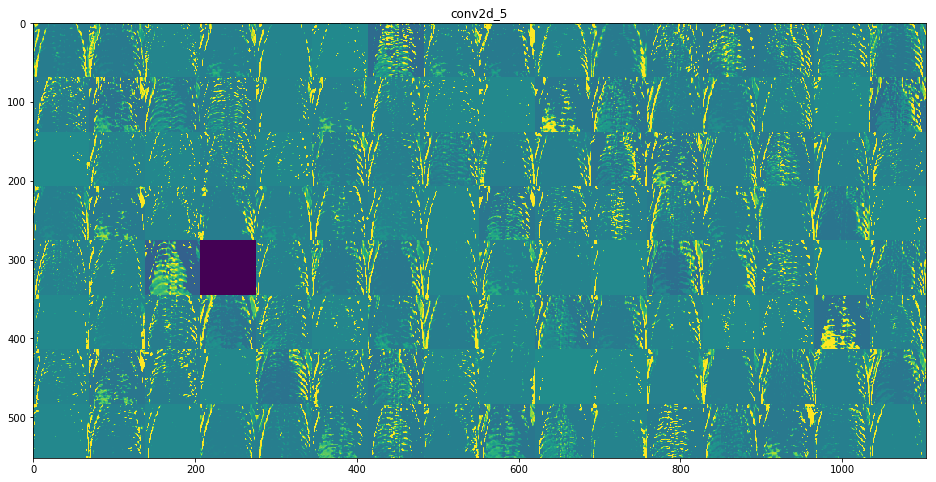

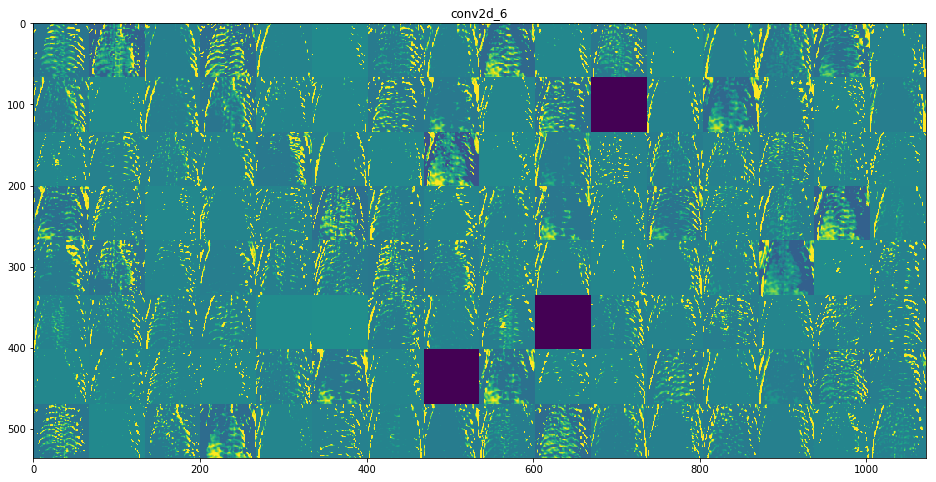

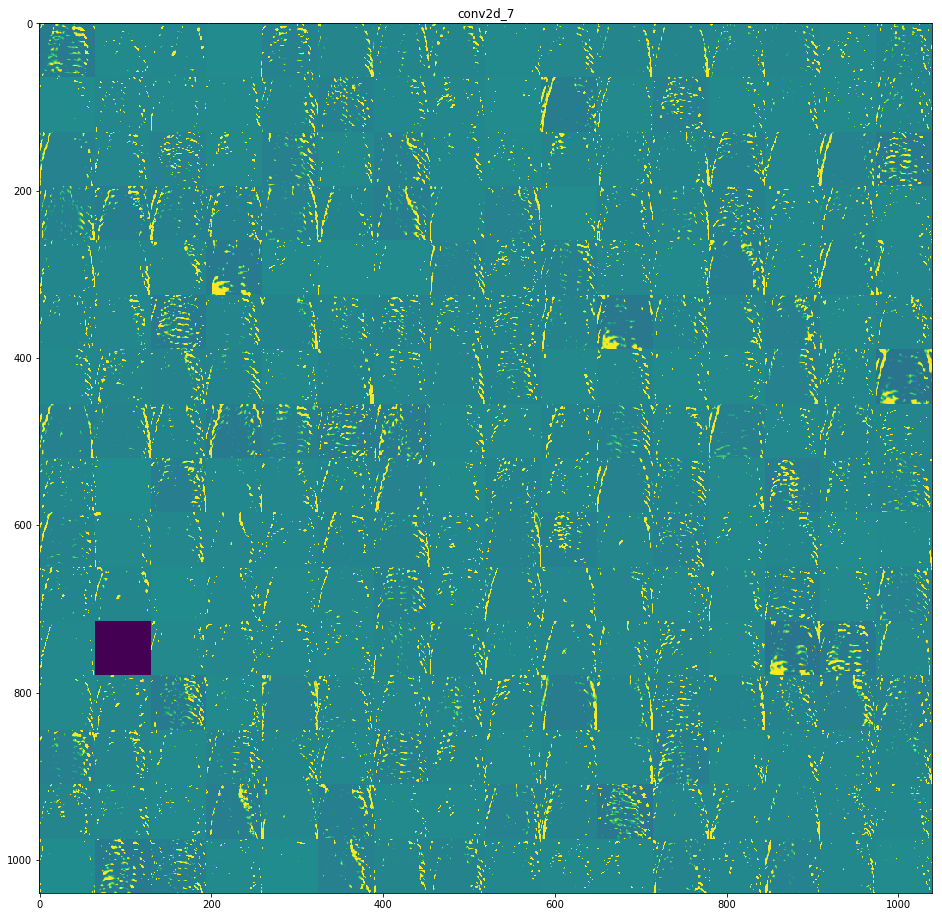

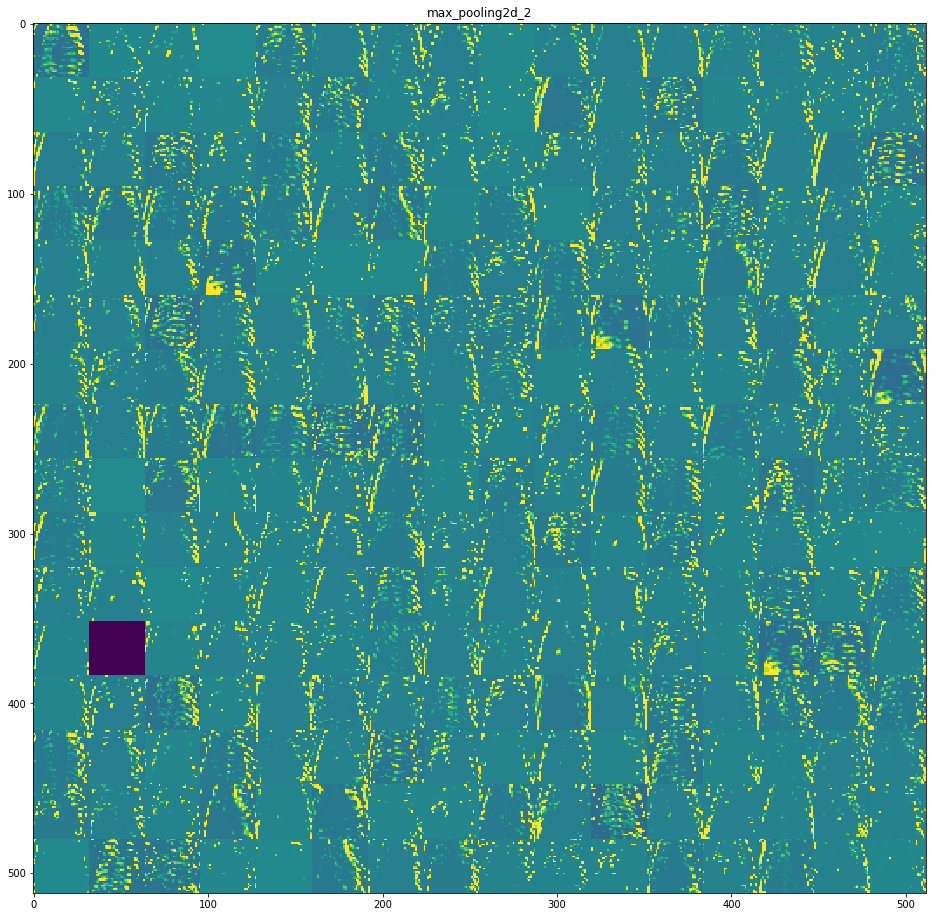

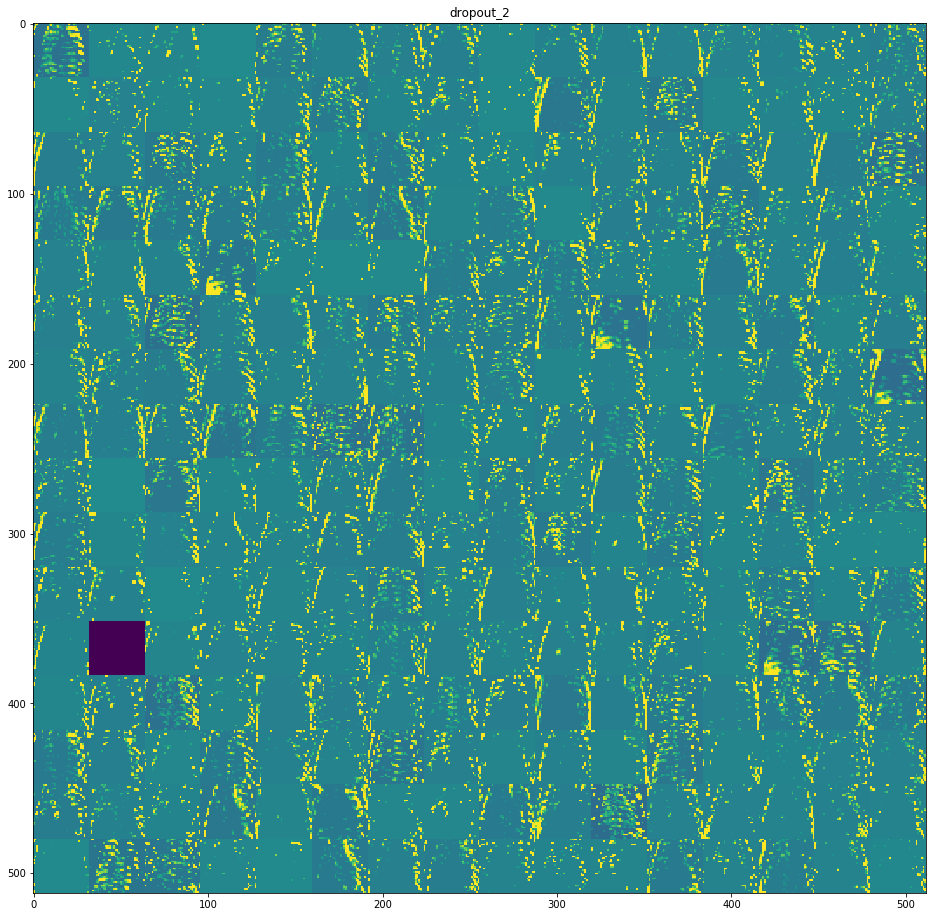

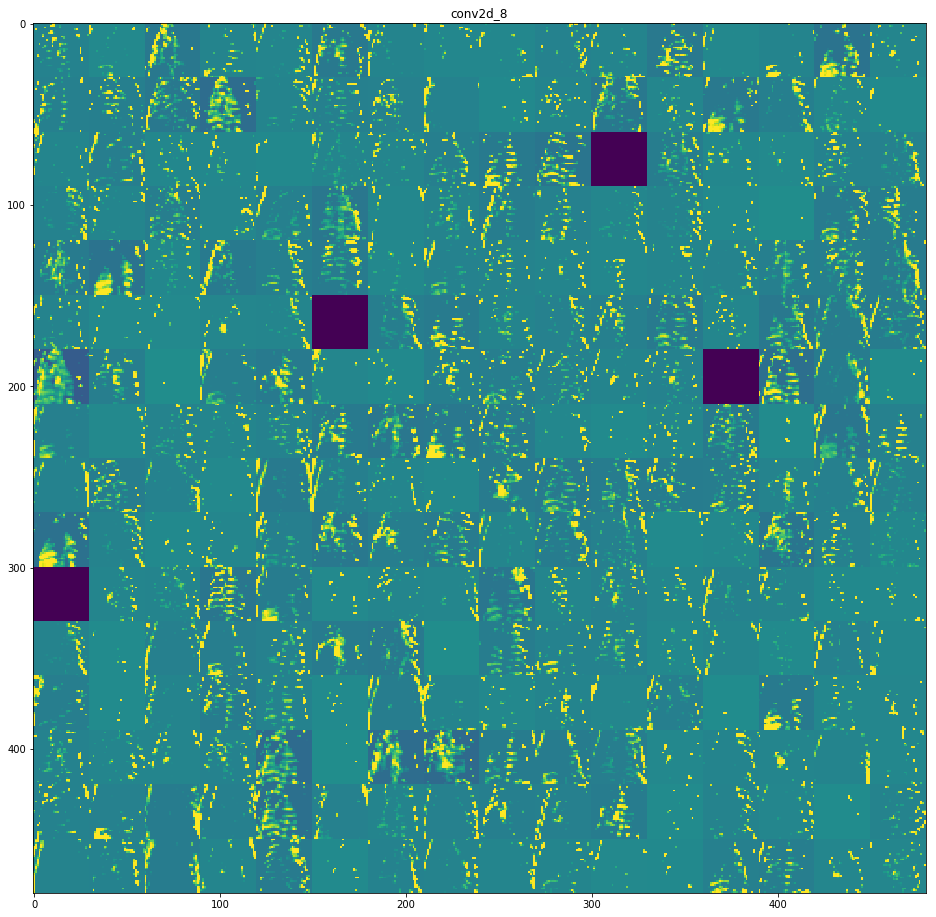

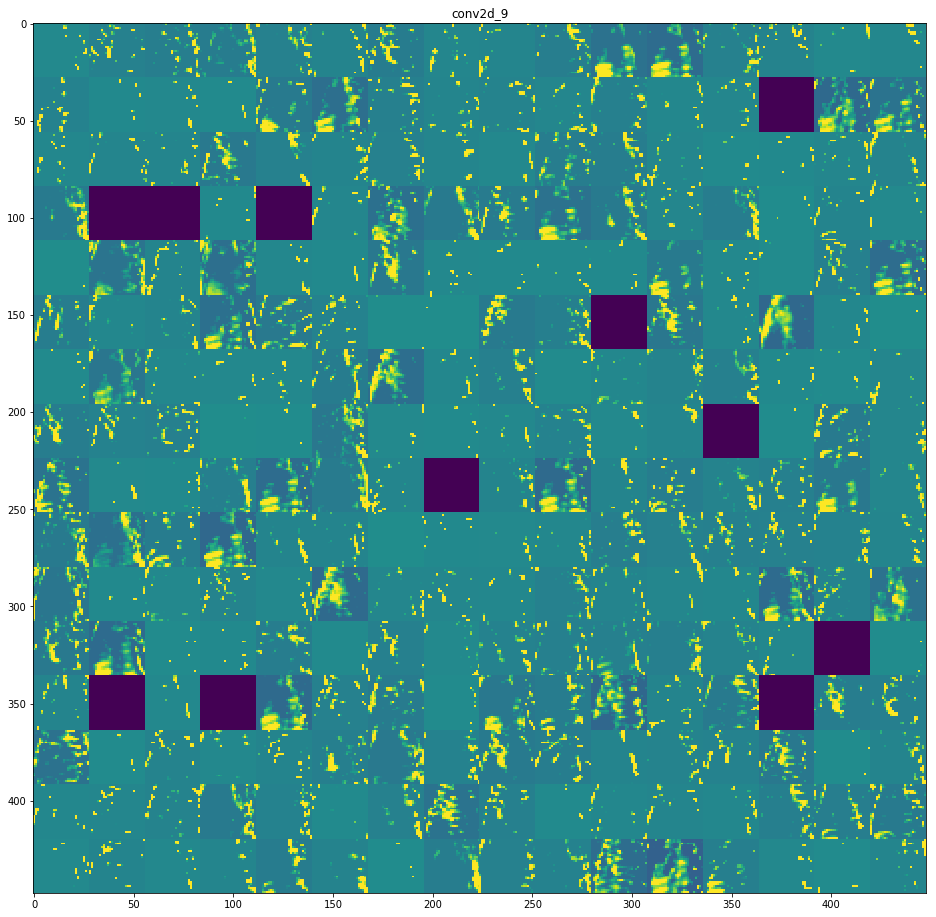

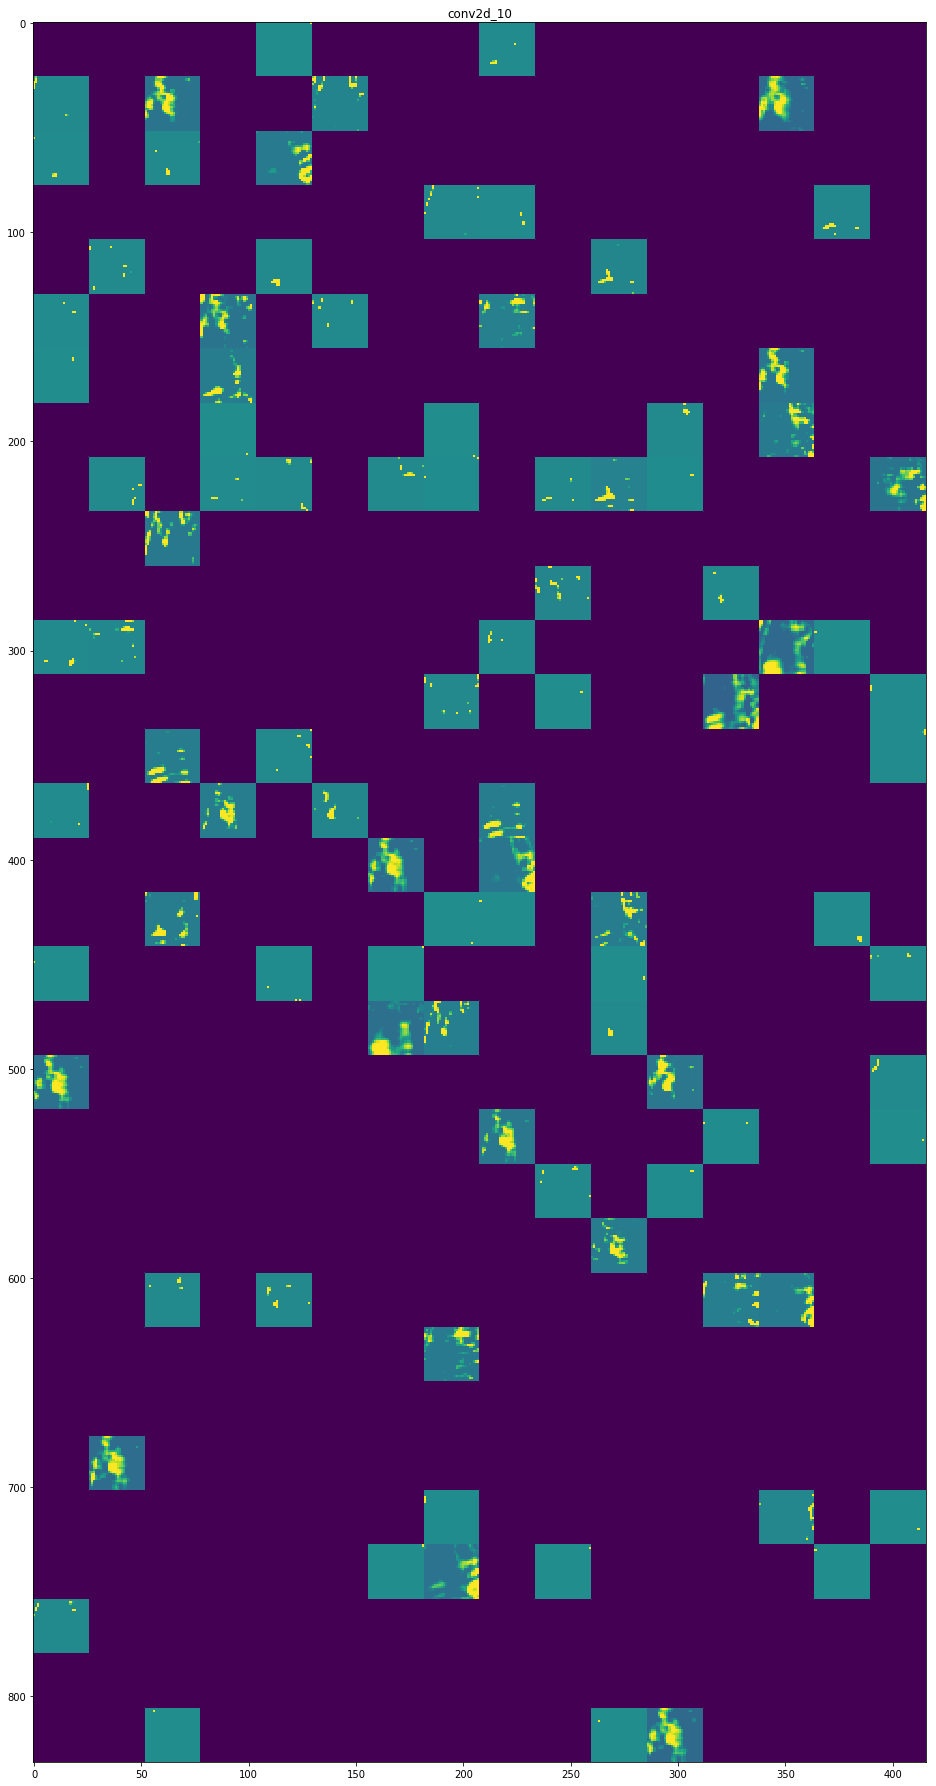

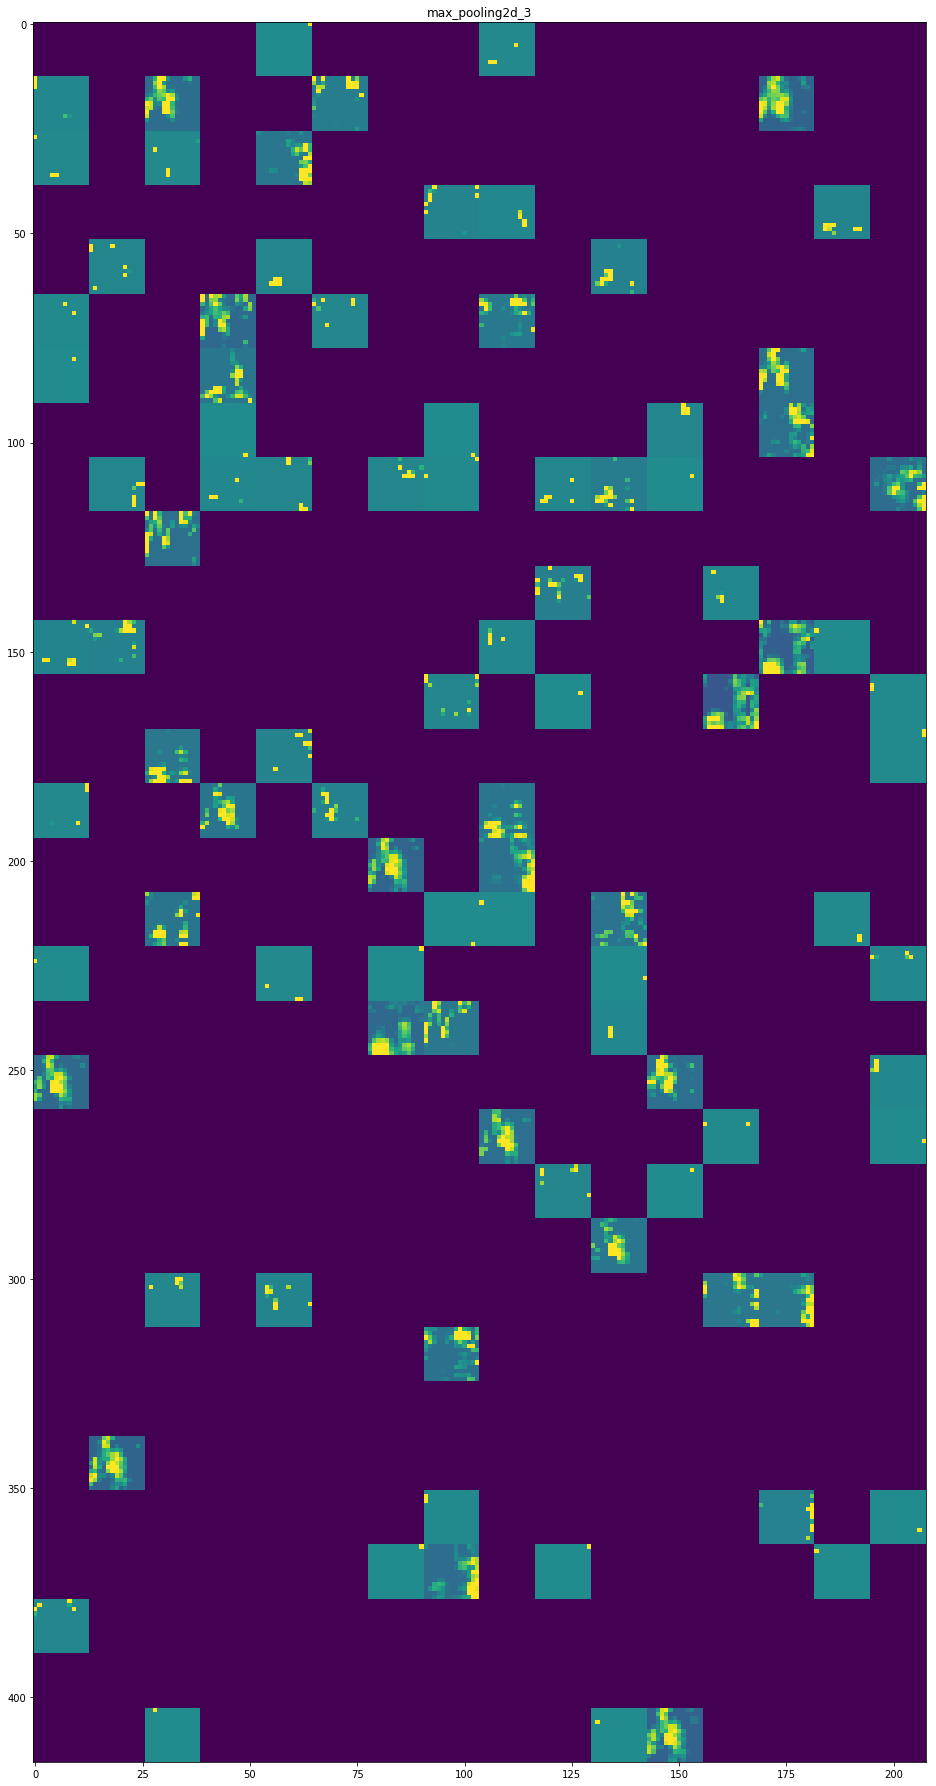

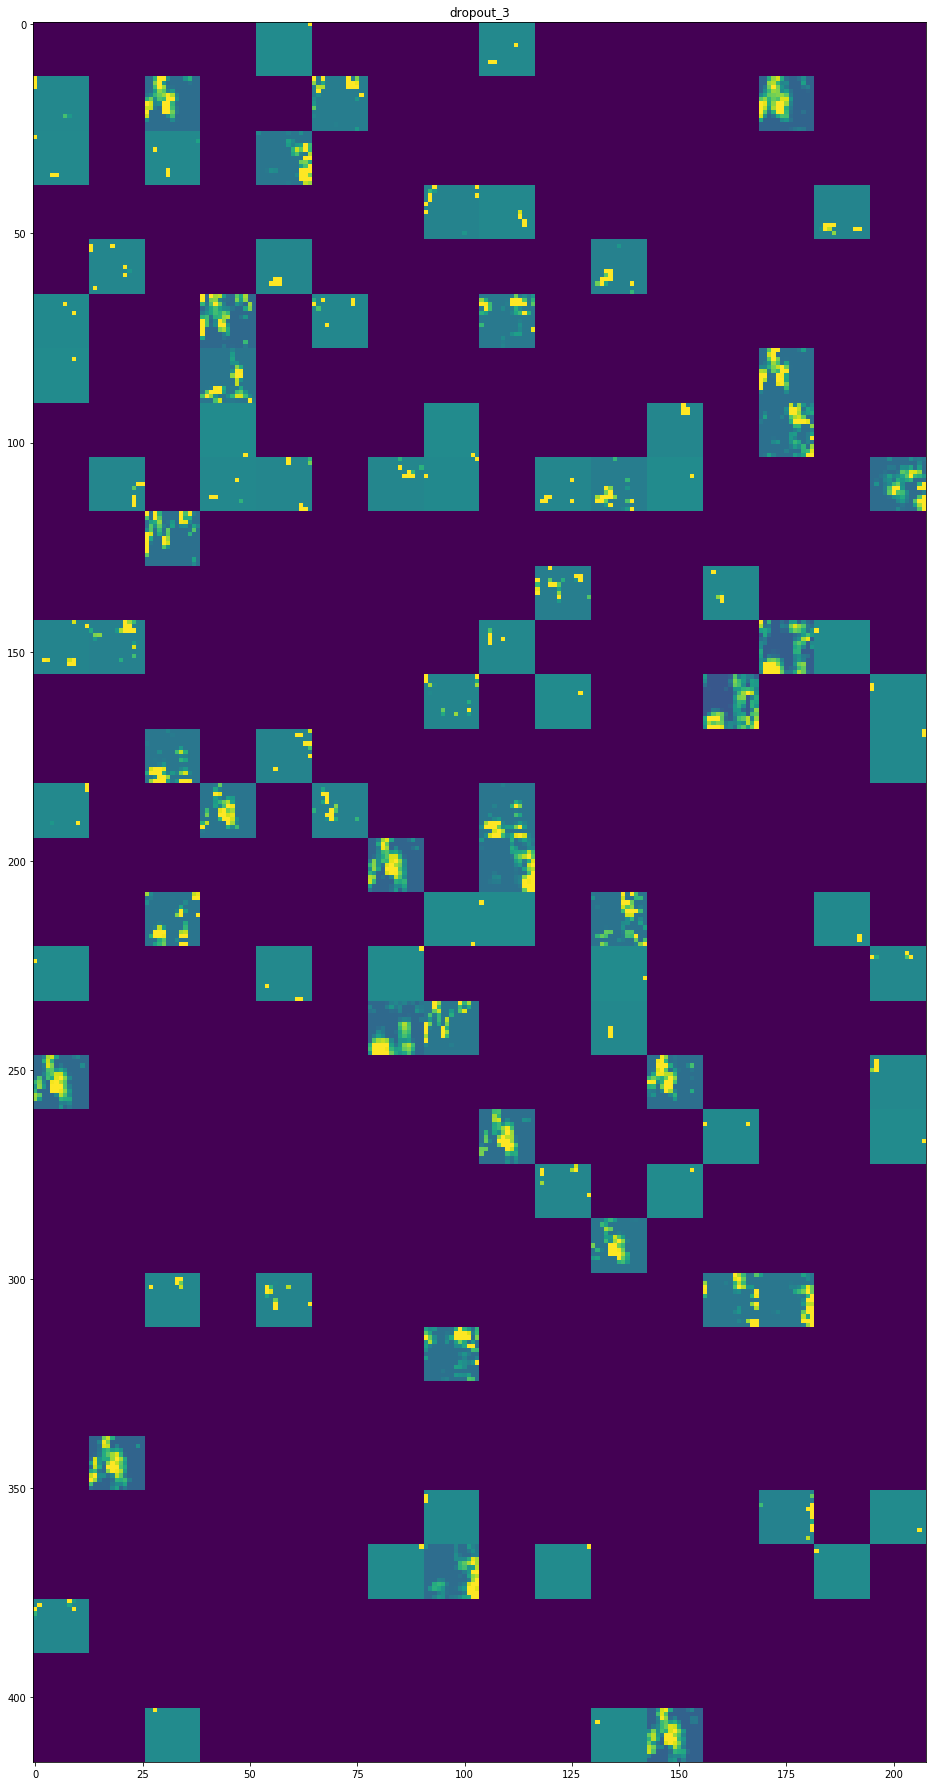

In [9]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:16]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

## Visualizing heatmaps of class activation
This visualization technique is useful for understanding which parts of a given image led PneumoniaNet to its final classification decision. The technique consists of producing heatmaps of "class activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for every location in any input image, indicating how important each location is with respect to the class considered.

The specific implementation used is described in this paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391).

In [10]:
from keras import backend as K

preds=model.predict(img_tensor)

In [11]:
print(preds[0])

[2.2253719e-09 1.0000000e+00]


In [12]:
print(np.argmax(preds[0]))

1


In [13]:
# This is the "pneumonia" entry in the prediction vector
pneumonia_output = model.output[:, 1]

# The is the output feature map of the `conv2d_9` layer,
# the last convolutional layer in PneumoniaNet
last_conv_layer = model.get_layer('conv2d_10')

# This is the gradient of the "Pneumonia" class with regard to
# the output feature map of `conv2d_9`
grads = K.gradients(pneumonia_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `conv2d_9`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample chest x-ray image
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the Pneumonia class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

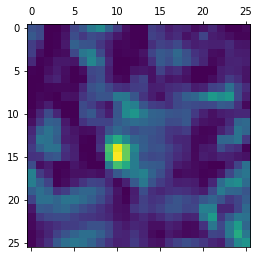

In [14]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [15]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('pneumonia_cam.jpg', superimposed_img)

True

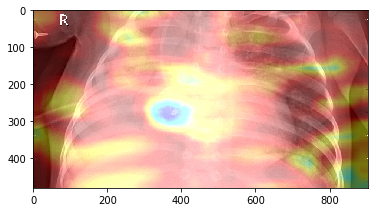

In [16]:
img_path2 = 'D:\\TensorFlow Programs\\Diagnosis of Pneumonia based on Chest X-Rays\\new experiments_from 24_08_2019\\pneumonia_cam.jpg'

img_array = cv2.imread(img_path2,1)  # convert to array
plt.imshow(img_array)  # graph it
plt.show()  # display!